特徴量の重みを正常に反映しているか確認するため、オッズ系統を全て抜いて学習させる。

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [40]:
data_dir = "F:/TARGET frontier/TXT34/"
data_name = "train"
tail = "fe3"
train_data = pd.read_csv(data_dir+data_name+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})

In [41]:
pd.set_option('display.max_columns', 100)
train_data.head()

,場所,芝・ダ,距離,クラス名,馬場状態,頭数,騎手,枠番,性別,年齢,キャリア,斤量,間隔,休み明け〜戦目,種牡馬,父タイプ名,所属,調教師,レースID(旧),確定着順,着差,単勝オッズ,複勝オッズ下限,複勝オッズ上限,複勝配当,前走レースID(旧),前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走出走頭数,替,前騎手,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走PCI3,前走RPCI,前PCI,前好走,前走確定着順,前走着差タイム,前走単勝オッズ,順位,頭数.1,場所距離芝ダ,前走場所距離芝ダ
0,2,2,1200,2,3,16,424,6,2,3,13,56.0,6.0,5.0,569,8,0,323,0615581112,1,0.0,5.4,1.9,2.7,190.0,0515531003,13,2,1400.0,2,2,15.0,0,284,2.0,3,54.0,37.2,33.9,59.53,58.2,59.7,0,8.0,0.2,14.6,1,16,49,42
1,2,2,1200,2,3,16,67,6,1,3,10,54.0,3.0,3.0,450,8,0,322,0615581111,2,0.0,2.8,1.3,1.6,130.0,0715420613,1,2,1200.0,1,3,18.0,1,67,7.0,3,54.0,34.5,34.6,48.80,46.9,49.7,0,1.0,0.0,2.2,2,16,49,15
2,2,2,1200,2,3,16,208,3,2,3,9,56.0,5.0,2.0,603,5,1,210,0615581106,3,0.2,6.2,1.8,2.5,180.0,0815551217,3,2,1200.0,2,3,18.0,0,137,8.0,2,56.0,34.5,34.4,50.13,48.0,50.3,0,7.0,0.4,28.6,3,16,49,187
3,2,2,1200,2,3,16,335,4,1,5,17,55.0,2.0,4.0,90,1,1,334,0615581108,4,0.3,6.6,1.7,2.5,0.0,0615540911,2,2,1200.0,2,2,16.0,1,335,6.0,2,53.0,34.1,34.4,48.17,46.3,49.1,0,3.0,0.0,19.1,4,16,49,111
4,2,2,1200,2,3,16,384,8,1,3,15,54.0,2.0,4.0,324,4,1,162,0615581116,5,0.3,33.9,6.3,9.7,0.0,0615540904,2,2,1200.0,2,2,16.0,0,212,2.0,5,53.0,33.6,36.4,48.17,46.3,42.3,1,13.0,1.5,8.6,5,16,49,111


In [60]:
#test_data
test_data = pd.read_csv(data_dir+"predict"+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})
test_x = test_data.drop(["着差","レースID(旧)","前走レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当","順位","確定着順","頭数.1","前走確定着順","替"],axis=1)
test_y = test_data["確定着順"]

In [61]:
train_x = train_data.drop(["着差","レースID(旧)","前走レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当","順位","確定着順","頭数.1","前走確定着順","替"],axis=1)
train_y = train_data["確定着順"]

In [62]:
train_x.columns

Index(['場所', '芝・ダ', '距離', 'クラス名', '馬場状態', '頭数', '騎手', '枠番', '性別', '年齢', 'キャリア',
       '斤量', '間隔', '休み明け〜戦目', '種牡馬', '父タイプ名', '所属', '調教師', '単勝オッズ', '前走場所',
       '前芝・ダ', '前距離', '前クラス名', '前走馬場状態', '前走出走頭数', '前騎手', '前走枠番', '前走脚質',
       '前走斤量', '前走Ave-3F', '前走上り3F', '前走PCI3', '前走RPCI', '前PCI', '前好走',
       '前走着差タイム', '前走単勝オッズ', '場所距離芝ダ', '前走場所距離芝ダ'],
      dtype='object')

In [63]:
#チューニング済みパラメータ(etaのみ手動)
params = {'colsample_bytree': 0.65, 
          'gamma': 0.013439667332810353, 
          'max_depth': 5, 
          'min_child_weight': 2.663317188920419, 
          'subsample': 0.9, 
          'booster': 'gbtree', 
          'objective': 'reg:squarederror', 
          'eta': 0.01, 
          'alpha': 0.0, 
          'lambda': 1.0, 
          'random_state': 71}

In [64]:
#これがないとエラー履くので注意
train_y.fillna(10,inplace=True) #無ければ10位に
test_y.fillna(10,inplace=True)

In [65]:
scores = []
histories = []
models = []
y = pd.Series()
kf = KFold(n_splits=4,shuffle=False)
for tr_idx,va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y)
    dvalid = xgb.DMatrix(va_x,label=va_y)
    watchlist = [(dtrain,"train"),(dvalid,"eval")]
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=500
    )
    models.append(model)
    histories.append(evals_result)
    va_pred = model.predict(dvalid)
    va_y.fillna(0.5,inplace=True)
    score = mean_squared_error(va_y,va_pred)
    score = np.sqrt(mean_squared_error(va_y,va_pred)) #rmse
    scores.append(score)
    
    #evaluationさせる
    #全部のfoldについてyに入れておいて、
    y_pred_proba = model.predict(dvalid)
    y = pd.concat([y,pd.Series(y_pred_proba)])


output = train_data
output = output.assign(ya=y.values)
output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/kfeval.csv",index=False,encoding="shift-jis")
    
print(*scores)
print(np.mean(scores))

[0]	train-rmse:8.54781	eval-rmse:8.63177
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.49708	eval-rmse:3.55877
[1000]	train-rmse:3.45332	eval-rmse:3.54004
[1500]	train-rmse:3.42515	eval-rmse:3.53558
[2000]	train-rmse:3.40121	eval-rmse:3.53383
[2500]	train-rmse:3.379	eval-rmse:3.53287
Stopping. Best iteration:
[2668]	train-rmse:3.37196	eval-rmse:3.53266

[0]	train-rmse:8.54718	eval-rmse:8.63251
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.49195	eval-rmse:3.56998
[1000]	train-rmse:3.44918	eval-rmse:3.55375
[1500]	train-rmse:3.42083	eval-rmse:3.54827
[2000]	train-rmse:3.3969	eval-rmse:3.54583
[2500]	train-rmse:3.37459	eval-rmse:3.54393
[3000]	train-rmse:3.35342	eval-rmse:3.54293
[3500]	train-rmse:3.33261	eval-rmse:3.54231
Stopping. Best iteration:
[3448]	tra

In [10]:
#学習結果のプロット
%matplotlib inline
def plot_loss(evals_result, title):
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()

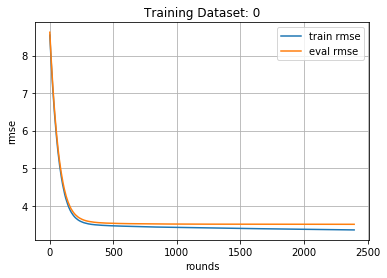

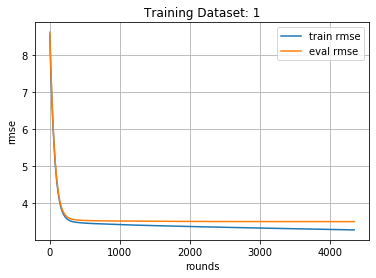

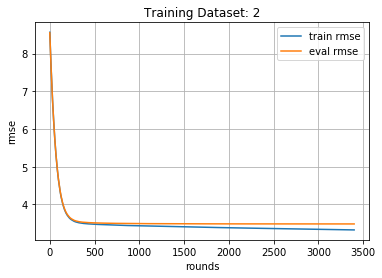

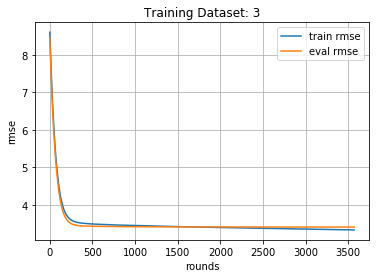

In [11]:
for i in range(4):
    plot_loss(histories[i],f'Training Dataset: {i}')

In [58]:
test_length = len(test_data)
predict = np.array([0.0]*test_length)
dtest = xgb.DMatrix(test_x,label=test_y) #本来は学習に使用していないデータにする
for i in range(4):
    y_pred_proba = models[i].predict(dtest)
    predict += y_pred_proba

predict /= 4

In [59]:
y = pd.DataFrame(predict,columns=["y'"])
output = test_data #ここも書き換えること

output = pd.concat([output,y],axis=1)

output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/neweval5.csv",index=False,encoding="shift-jis")

In [50]:
fscore = model.get_score(importance_type="total_gain")
fscore = sorted([(k,v) for k,v in fscore.items()] ,key=lambda tpl: tpl[1], reverse = True)
print(*fscore[:20])

('単勝オッズ', 28349235.88914128) ('前走確定着順', 5306282.408315896) ('頭数', 4526072.378321479) ('前走単勝オッズ', 4409081.02893101) ('前走着差タイム', 950135.1272081209) ('前好走', 890647.4626655708) ('間隔', 654736.4925553976) ('前走Ave-3F', 611646.004177367) ('前走脚質', 388831.5041715663) ('前PCI', 364974.84890341735) ('キャリア', 330431.3184503956) ('前距離', 330088.9965650792) ('騎手', 324358.30882888957) ('休み明け〜戦目', 317077.0695063283) ('前クラス名', 316033.42004079005) ('前走PCI3', 308775.82180056546) ('クラス名', 267570.4481953326) ('前走上り3F', 265974.06890706555) ('種牡馬', 265162.95326388977) ('調教師', 232312.13421193475)


In [51]:
#全体を100[%]とした時の重要度
mother = sum([j for i,j in fscore])
for i,j in fscore[:25]:
    print(i,round((j/mother)*100,1))

単勝オッズ 54.8
前走確定着順 10.3
頭数 8.7
前走単勝オッズ 8.5
前走着差タイム 1.8
前好走 1.7
間隔 1.3
前走Ave-3F 1.2
前走脚質 0.8
前PCI 0.7
キャリア 0.6
前距離 0.6
騎手 0.6
休み明け〜戦目 0.6
前クラス名 0.6
前走PCI3 0.6
クラス名 0.5
前走上り3F 0.5
種牡馬 0.5
調教師 0.4
距離 0.4
前走出走頭数 0.4
前走RPCI 0.4
場所距離芝ダ 0.4
前騎手 0.4


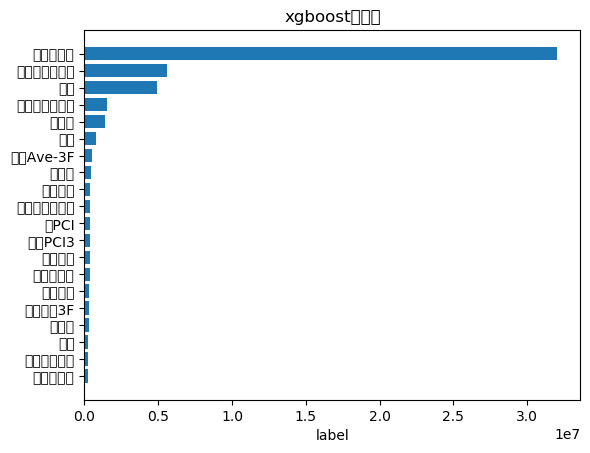

In [29]:
slen = 20
label = []
weight = []
for i,j in fscore[:slen]:
    label.append(i)
    weight.append(j)

plt.rcdefaults() #横棒グラフモード
fig, ax = plt.subplots()
y_pos = np.arange(slen)
ax.barh(y_pos, weight,align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()
ax.set_xlabel('label')
ax.set_title('xgboost特徴量')
plt.show()
    

In [17]:
#save models
import pickle
with open('xgmachina_ver0.0.7.pickle', mode='wb') as fp:
    pickle.dump(models, fp)

In [18]:
#import models
"""import pickle
with open('xgmachina_ver0.0.6.pickle', mode='rb') as fp:
    models = pickle.load(fp)"""

"import pickle\nwith open('xgmachina_ver0.0.6.pickle', mode='rb') as fp:\n    models = pickle.load(fp)"